In [1]:
import s4bi
import matplotlib.pyplot as plt
from importlib import reload
from scipy import constants
from astropy.cosmology import Planck15
import qubic
from qubic import mcmc
import healpy as hp
import numpy as np
import os
import qubicplus
#import fgbuster
import fgbuster
from qubic import NamasterLib as nam
center = qubic.equ2gal(0, -57)
from fgbuster.component_model import (CMB, Dust, Dust_2b, Synchrotron, AnalyticComponent)
from fgbuster import basic_comp_sep, get_instrument
# If there is not this command, the kernel shut down every time..
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import pickle
import sys
from qubic import AnalysisMC as amc
from qubic import camb_interface as qc
import scipy

import pickle

def get_coverage(fsky, nside, center_radec=[0., -57.]):
    center = qubic.equ2gal(center_radec[0], center_radec[1])
    uvcenter = np.array(hp.ang2vec(center[0], center[1], lonlat=True))
    uvpix = np.array(hp.pix2vec(nside, np.arange(12*nside**2)))
    ang = np.arccos(np.dot(uvcenter, uvpix))
    indices = np.argsort(ang)
    okpix = ang < -1
    okpix[indices[0:int(fsky * 12*nside**2)]] = True
    mask = np.zeros(12*nside**2)
    mask[okpix] = 1
    return mask

covmap = get_coverage(0.03, nside=256)

In [14]:
def plot_errors_lines(leff, err, dl, s, color='r', label=''):
    for i in range(len(leff)):
        if i==0:
            plt.plot([leff[i]-dl/2, leff[i]+dl/2], [err[i, i,s], err[i, i,s]],color, label=label)
        else:
            plt.plot([leff[i]-dl/2, leff[i]+dl/2], [err[i, i,s], err[i, i,s]],color)
        if i < (len(leff)-1):
            plt.plot([leff[i]+dl/2,leff[i]+dl/2], [err[i, i,s], err[i+1, i+1,s]], color)

def ana_likelihood(rv, leff, fakedata, errors, model, prior, 
                   mylikelihood=mcmc.LogLikelihood, covariance_model_funct=None, otherp=None):
    ll = mylikelihood(xvals=leff, yvals=fakedata, errors=errors, 
                            model = model, flatprior=prior, covariance_model_funct=covariance_model_funct)  

    like = np.zeros_like(rv)
    for i in range(len(rv)):
        like[i] = np.exp(ll([rv[i]]))
    cumint = scipy.integrate.cumtrapz(like, x=rv)
    cumint = cumint / np.max(cumint)
    onesigma = np.interp(0.68, cumint, rv[1:])
    if otherp:
        other = np.interp(otherp, cumint, rv[1:])
        return like, cumint, onesigma, other
    else:
        return like, cumint, onesigma


def explore_like(leff, mcl_noise, errors, lmin, dl, cc, rv, otherp=None,
                 cov=None, plotlike=False, plotcls=False, 
                 verbose=False, sample_variance=True, mytitle='', color=None, mylabel='',my_ylim=None):
    
#     print(lmin, dl, cc)
#     print(leff)
#     print(scl_noise[:,2])
    ### Create Namaster Object
    # Unfortunately we need to recalculate fsky for calculating sample variance
    nside = 256
    lmax = 2 * nside - 1
    if cov is None:
        Namaster = nam.Namaster(None, lmin=lmin, lmax=lmax, delta_ell=dl)
        Namaster.fsky = 0.018
    else:
        okpix = cov > (np.max(cov) * float(cc))
        maskpix = np.zeros(12*nside**2)
        maskpix[okpix] = 1
        Namaster = nam.Namaster(maskpix, lmin=lmin, lmax=lmax, delta_ell=dl)
    
#     print('Fsky: {}'.format(Namaster.fsky))
    lbinned, b = Namaster.get_binning(nside)

    ### Bibnning CambLib
#     binned_camblib = qc.bin_camblib(Namaster, '../../scripts/QubicGeneralPaper2020/camblib.pickle', 
#                                     nside, verbose=False)
    binned_camblib = qc.bin_camblib(Namaster, 'camblib.pkl', 
                                    nside, verbose=False)


    ### Redefine the function for getting binned Cls
    def myclth(ell,r):
        clth = qc.get_Dl_fromlib(ell, r, lib=binned_camblib, unlensed=False)[0]
        return clth
    allfakedata = myclth(leff, 0.)
    
    ### And we need a fast one for BB only as well
    def myBBth(ell, r):
        clBB = qc.get_Dl_fromlib(ell, r, lib=binned_camblib, unlensed=False, specindex=2)[0]
        return clBB

    ### Fake data
    fakedata = myBBth(leff, 0.)
    
    if sample_variance:
        covariance_model_funct = Namaster.knox_covariance
    else:
        covariance_model_funct = None
    if otherp is None:
        like, cumint, allrlim = ana_likelihood(rv, leff, fakedata, 
                                            errors, 
                                            myBBth, [[0,1]],
                                           covariance_model_funct=covariance_model_funct)
    else:
        like, cumint, allrlim, other = ana_likelihood(rv, leff, fakedata, 
                                            errors, 
                                            myBBth, [[0,1]],
                                           covariance_model_funct=covariance_model_funct, otherp=otherp)
    
    if plotcls:
        if plotlike:
            plt.subplot(1,2,1)
            if np.ndim(BBcov) == 2:
                errorstoplot = np.sqrt(np.diag(errors))
            else:
                errorstoplot = errors
        #plot(inputl, inputcl[:,2], 'k', label='r=0')
        plt.plot(leff, errorstoplot, label=mylabel+' Errors', color=color)
        plt.xlim(0,lmax)
        if my_ylim is None:
            plt.ylim(1e-4,1e0)
        else:
            plt.ylim(my_ylim[0], my_ylim[1])
        plt.yscale('log')
        plt.xlabel('$\\ell$')
        plt.ylabel('$D_\\ell$')
        plt.legend(loc='upper left')
    if plotlike:
        if plotcls:
            plt.subplot(1,2,2)
        p=plt.plot(rv, like/np.max(like), 
               label=mylabel+' $\sigma(r)={0:6.4f}$'.format(allrlim), color=color)
        plt.plot(allrlim+np.zeros(2), [0,1.2], ':', color=p[0].get_color())
        plt.xlabel('r')
        plt.ylabel('posterior')
        plt.legend(fontsize=8, loc='upper right')
        plt.xlim(0,0.1)
        plt.ylim(0,1.2)
        plt.title(mytitle)
    
    if otherp is None:
        return like, cumint, allrlim
    else:
        return like, cumint, allrlim, other

In [34]:
N=20
nb_exp=5
tabper=[5, 10, 15, 20]
number_of_per=len(tabper)
cl_noise_s4 = np.zeros(((((N*nb_exp, 1, 16, 4)))))
cl_noise_bi = np.zeros(((((N*nb_exp, 1, 16, 4)))))
all_like_bi = np.zeros((number_of_per, 1000))
rlim68_bi = np.zeros(number_of_per)
rlim95_bi = np.zeros(number_of_per)

# Loading parameters

T_bi = np.zeros((len(tabper), N*nb_exp))
beta0_bi = np.zeros((len(tabper), N*nb_exp))
beta1_bi = np.zeros((len(tabper), N*nb_exp))
betapl_bi = np.zeros((len(tabper), N*nb_exp))

T_s4 = np.zeros((len(tabper), N*nb_exp))
beta0_s4 = np.zeros((len(tabper), N*nb_exp))
beta1_s4 = np.zeros((len(tabper), N*nb_exp))
betapl_s4 = np.zeros((len(tabper), N*nb_exp))

covbin_bi_tab=[]

for indper, per in enumerate(tabper):
    print(indper, per)
    
    for i in range(N):

        with open('results/clnoise_{}reals_percent{}_{}.pkl'.format(nb_exp, per, i+1), 'rb') as f:
            data = pickle.load(f)
            cl_noise_s4[i*nb_exp:(i+1)*nb_exp, :]=data['cl_noise_s4']
            cl_noise_bi[i*nb_exp:(i+1)*nb_exp, :]=data['cl_noise_bi']
            T_bi[indper, i*nb_exp:(i+1)*nb_exp]=data['Tbi']
            beta0_bi[indper, i*nb_exp:(i+1)*nb_exp]=data['beta0bi']
            beta1_bi[indper, i*nb_exp:(i+1)*nb_exp]=data['beta1bi']
            betapl_bi[indper, i*nb_exp:(i+1)*nb_exp]=data['betaplbi']
            
            T_s4[indper, i*nb_exp:(i+1)*nb_exp]=data['T_s4']
            beta0_s4[indper, i*nb_exp:(i+1)*nb_exp]=data['beta0s4']
            beta1_s4[indper, i*nb_exp:(i+1)*nb_exp]=data['beta1s4']
            betapl_s4[indper, i*nb_exp:(i+1)*nb_exp]=data['betapls4']


    
    scl_s4 = np.std(cl_noise_s4, axis=0)
    #covbin_s4, corrbin = amc.get_covcorr_patch(cl_noise_s4[:, 0], stokesjoint=True, doplot=False)
    scl_bi = np.std(cl_noise_bi, axis=0)
    
    #covbin_bi, corrbin = amc.get_covcorr_patch(cl_noise_bi[:, 0], stokesjoint=True, doplot=False)
    
    leff=data['leff']
    lmin=40
    lmax=2*256-1
    delta_ell=30


    ### BB sigmas
    sclBB_s4 = scl_s4[0, :, 2]
    sclBB_bi = scl_bi[0, :, 2]
    
    cl_noise_bi_reshape = np.moveaxis(cl_noise_bi, [1, 2, 3], [3, 1, 2])
    cl_noise_s4_reshape = np.moveaxis(cl_noise_s4, [1, 2, 3], [3, 1, 2])

    covbin_bi, _ = amc.get_covcorr_patch(cl_noise_bi_reshape, stokesjoint=True, doplot=False)
    covbin_s4, _ = amc.get_covcorr_patch(cl_noise_s4_reshape, stokesjoint=True, doplot=False)
    
    covbin_bi_tab.append(covbin_bi)
    
    BBcov_s4 = covbin_s4[:, :, 2]
    BBcov_bi = covbin_bi[:, :, 2]
    
    #to_use_bi = sclBB_bi.copy()
    method='sigma'
    if method=='sigma':
        to_use_s4 = sclBB_s4.copy()
        to_use_bi = sclBB_bi.copy()
    if method=='covariance':
        to_use_s4 = BBcov_s4.copy()
        to_use_bi = BBcov_bi.copy()
    

    ### Likelihood
    #camblib = qc.read_camblib(global_dir + '/doc/CAMB/camblib.pkl')
    rv = np.linspace(0,0.1,1000)
    if indper == 0:
        like_s4, cumint_s4, rlim68_s4, rlim95_s4 = explore_like(leff, sclBB_s4, to_use_s4, lmin, delta_ell, 0.1, rv,
                                     cov=covmap, plotlike=False, plotcls=False,
                                     verbose=True, sample_variance=True, otherp=0.95)

    rv = np.linspace(0,0.1,1000)
    all_like_bi[indper], cumint_bi, rlim68_bi[indper], rlim95_bi[indper] = explore_like(leff, sclBB_bi, to_use_bi, lmin, delta_ell, 0.1, rv,
                                     cov=covmap, plotlike=False, plotcls=False,
                                     verbose=True, sample_variance=True, otherp=0.95)

0 5
1 10
2 15
3 20


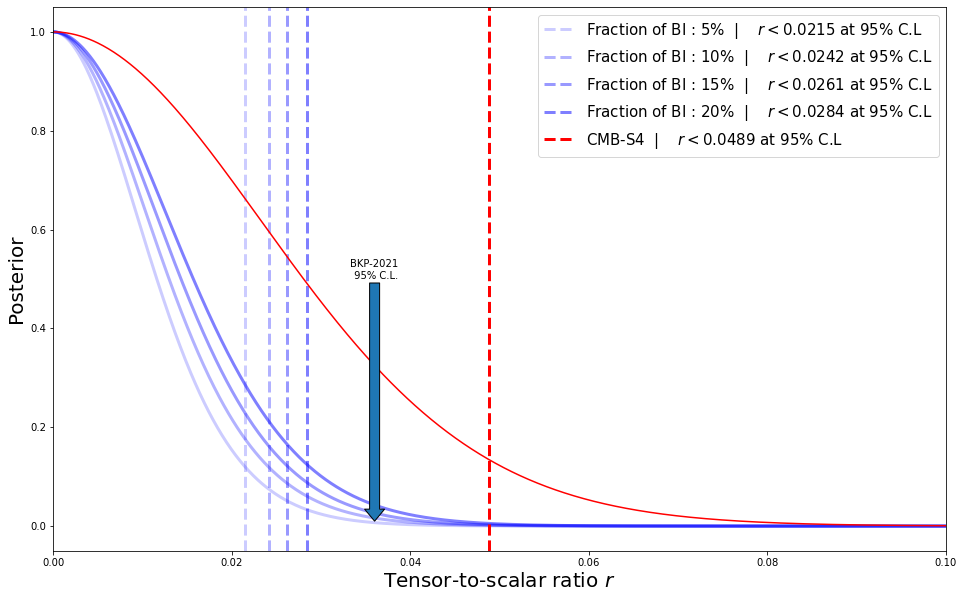

In [10]:
plt.figure(figsize=(16, 10))

for i in range(number_of_per):
    plt.plot(rv, all_like_bi[i], '-b', alpha=0.2+(i*0.1), lw=3)

    plt.axvline(rlim95_bi[i], color='blue', alpha=0.2+(i*0.1), lw=3, ls='--', label=r'Fraction of BI : {}%  |    $r < {:.4f}$ at 95% C.L'.format(tabper[i], rlim95_bi[i]))
        
plt.plot(rv, like_s4, 'r')

plt.axvline(rlim95_s4, color='red', lw=3, ls='--', label=r'CMB-S4  |    $r < {:.4f}$ at 95% C.L'.format(rlim95_s4))

plt.annotate("BKP-2021\n 95% C.L.", xy=(0.036, 0.01), xytext=(0.036, 0.5),
            arrowprops=dict(width=10, headwidth=20), ha='center')

plt.xlim(0, 0.1)
plt.legend(fontsize=15)
plt.xlabel(r'Tensor-to-scalar ratio $r$', fontsize=20)
plt.ylabel('Posterior', fontsize=20)
plt.show()

In [70]:
iper=2
print("T = {:.6f} +- {:.6f}".format(np.mean(T_s4, axis=1)[iper], np.std(T_s4, axis=1)[iper]))
print("T = {:.6f} +- {:.6f}\n".format(np.mean(T_bi, axis=1)[iper], np.std(T_bi, axis=1)[iper]))

print("beta0 = {:.6f} +- {:.6f}".format(np.mean(beta0_s4, axis=1)[iper], np.std(beta0_s4, axis=1)[iper]))
print("beta0 = {:.6f} +- {:.6f}\n".format(np.mean(beta0_bi, axis=1)[iper], np.std(beta0_bi, axis=1)[iper]))

print("beta1 = {:.6f} +- {:.6f}".format(np.mean(beta1_s4, axis=1)[iper], np.std(beta1_s4, axis=1)[iper]))
print("beta1 = {:.6f} +- {:.6f}\n".format(np.mean(beta1_bi, axis=1)[iper], np.std(beta1_bi, axis=1)[iper]))

print("beta_pl = {:.6f} +- {:.6f}".format(np.mean(betapl_s4, axis=1)[iper], np.std(betapl_s4, axis=1)[iper]))
print("beta_pl = {:.6f} +- {:.6f}".format(np.mean(betapl_bi, axis=1)[iper], np.std(betapl_bi, axis=1)[iper]))

T = 20.034499 +- 0.000022
T = 20.073471 +- 0.000426

beta0 = 1.452252 +- 0.000663
beta0 = 1.438947 +- 0.000428

beta1 = 0.524655 +- 0.000042
beta1 = 1.638952 +- 0.001357

beta_pl = -3.001536 +- 0.000422
beta_pl = -3.000059 +- 0.000186
